# 图像特征提取与映射算法
实现多模态视觉特征处理流水线

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


## 1. 基础特征提取器
支持多种预训练骨干网络

In [2]:
class BaseFeatureExtractor(nn.Module):
    def __init__(self, backbone='resnet50', pretrained=True):
        super().__init__()

        # 选择骨干网络
        if backbone.startswith('resnet'):
            self.model = getattr(models, backbone)(pretrained=pretrained)
            in_features = self.model.fc.in_features
            self.model.fc = nn.Identity()  # 移除全连接层
        elif backbone.startswith('vit'):
            self.model = models.vit_b_16(pretrained=pretrained)
            in_features = self.model.heads.head.in_features
            self.model.heads = nn.Identity()  # 移除分类头
        else:
            raise ValueError(f"不支持的骨干网络: {backbone}")

        self.in_features = in_features
        self.backbone_type = backbone

    def forward(self, x):
        # 统一输入处理
        if 'vit' in self.backbone_type:
            x = self.model._process_input(x)  # ViT特殊预处理
            n = x.shape[0]
            batch_class_token = self.model.class_token.expand(n, -1, -1)
            x = torch.cat([batch_class_token, x], dim=1)
            x = self.model.encoder(x)
            return x[:, 0]  # 返回cls token
        else:
            return self.model(x)


## 2. 特征映射模块
将特征投影到目标嵌入空间

In [3]:
class FeatureProjector(nn.Module):
    def __init__(self, in_dim, out_dim, use_bn=True):
        super().__init__()
        layers = []
        if use_bn:
            layers.append(nn.BatchNorm1d(in_dim))
        layers.extend([
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.LayerNorm(out_dim)
        ])
        self.projection = nn.Sequential(*layers)

    def forward(self, x):
        return self.projection(x)


## 3. 完整处理流水线
整合特征提取与映射

In [4]:
class VisualFeatureProcessor(nn.Module):
    def __init__(self,
                 backbone='resnet50',
                 proj_dim=512,
                 freeze_backbone=True):
        super().__init__()

        # 特征提取器
        self.extractor = BaseFeatureExtractor(backbone)
        if freeze_backbone:
            for param in self.extractor.parameters():
                param.requires_grad_(False)

        # 特征映射
        self.projector = FeatureProjector(
            self.extractor.in_features,
            proj_dim
        )

        # 归一化层
        self.norm = nn.LayerNorm(proj_dim)

    def forward(self, images):
        # 特征提取
        features = self.extractor(images)

        # 特征投影
        projected = self.projector(features)

        # 层归一化
        return self.norm(projected)


## 4. 测试验证
验证模型前向传播

In [5]:
if __name__ == "__main__":
    # 配置参数
    config = {
        'backbone': 'resnet50',
        'proj_dim': 256,
        'freeze_backbone': True
    }

    # 初始化模型
    model = VisualFeatureProcessor(**config)

    # 创建测试输入 (batch_size, channels, height, width)
    dummy_input = torch.randn(4, 3, 224, 224)

    # 前向传播
    with torch.no_grad():
        output = model(dummy_input)

    print("输入形状:", dummy_input.shape)
    print("输出形状:", output.shape)  # 应为(4, 256)
    print("特征范数:", torch.norm(output, dim=1))  # 观察归一化效果

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


输入形状: torch.Size([4, 3, 224, 224])
输出形状: torch.Size([4, 256])
特征范数: tensor([15.9999, 15.9999, 15.9999, 15.9999])



## 5. 特征可视化分析
使用降维方法可视化特征分布

In [6]:
class FeatureVisualizer:
    @staticmethod
    def visualize(features, labels=None, method='PCA'):
        # 转换特征为numpy数组
        feat_np = features.cpu().numpy()

        # 降维处理
        if method == 'PCA':
            reducer = PCA(n_components=2)
        elif method == 'TSNE':
            reducer = TSNE(n_components=2)
        else:
            raise ValueError("不支持的降维方法")

        reduced = reducer.fit_transform(feat_np)

        # 可视化
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels)
        plt.title(f'{method} Feature Visualization')
        plt.colorbar(scatter)
        plt.show()


## 6. 端到端示例
完整处理流程演示

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 152MB/s]


原始特征维度: torch.Size([100, 128])


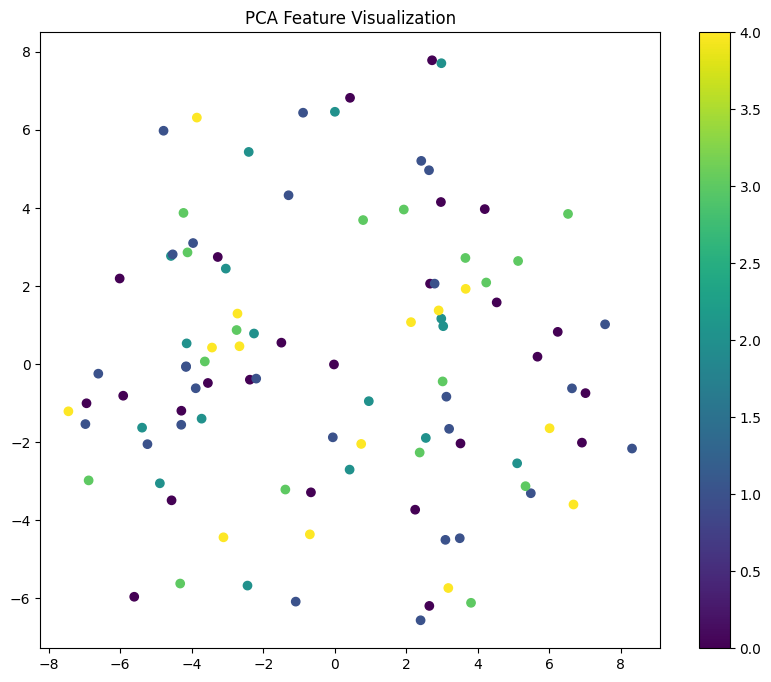

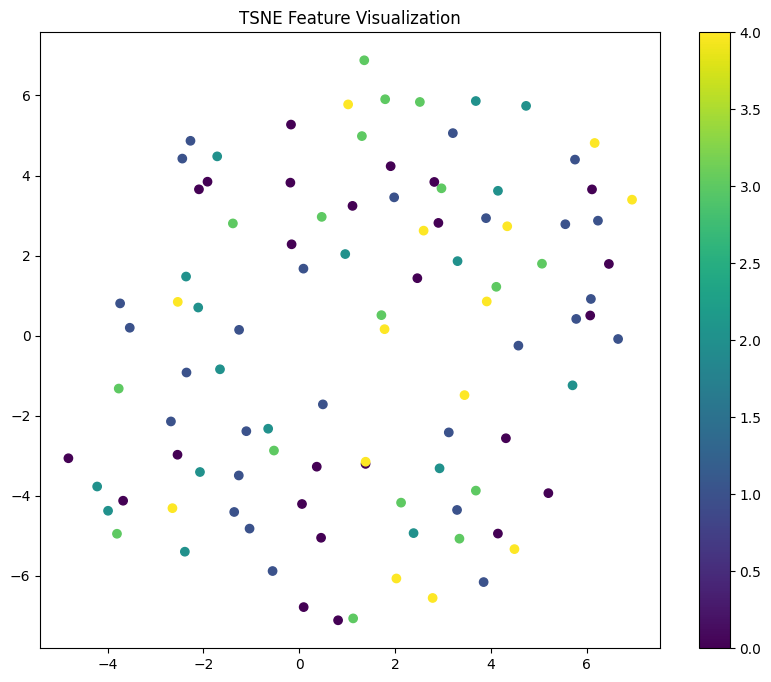

In [7]:
def full_pipeline_example():
    # 1. 创建模拟数据
    num_samples = 100
    images = torch.randn(num_samples, 3, 224, 224)
    labels = np.random.randint(0, 5, size=num_samples)  # 5个伪类别

    # 2. 初始化处理模型
    processor = VisualFeatureProcessor(backbone='vit_b_16', proj_dim=128)

    # 3. 特征提取与映射
    with torch.no_grad():
        features = processor(images)

    # 4. 可视化
    print("原始特征维度:", features.shape)
    FeatureVisualizer.visualize(features, labels, method='PCA')
    FeatureVisualizer.visualize(features, labels, method='TSNE')

# 执行示例
full_pipeline_example()